# Tinker+ (2017) SMHM-relations

Here we will fit the Tinker+ (2017) stellar mass-to-halo mass transformations. We use a digitized version of Figure 10 from Tinker+, fitting to the mean halo mass per stellar mass curve having $\log M_* = 0.18$ dex. (_This is the green dashed line in the left side of Figure 10._)

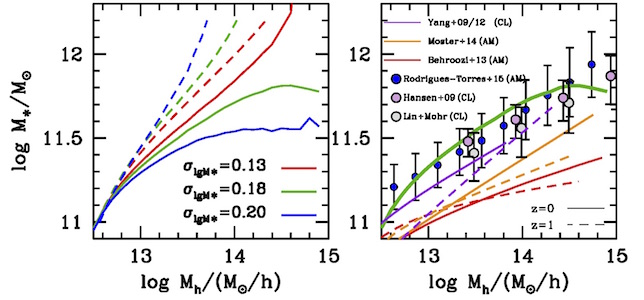

# 1. Fit to the digitized version of Tinker+ (2017) Figure 10

In [1]:
##Set up matplotlib for display in the browser:
%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=250)

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table,Column

### 1.1 Read in the digitized Tinker data 
The digitized version of Figure 10 (above) was created using [WebPlotDigitizer](http://arohatgi.info/WebPlotDigitizer/).

In [63]:
# Read the digitized version from CSV [made using http://arohatgi.info/WebPlotDigitizer/]
tinker_data = ascii.read('tinker2017-SMHMrelation.csv',data_start=0,
                         names=['log_mhalo','log_mstar'])
mhalo_tinker = tinker_data['log_mhalo'].data
mstar_tinker = tinker_data['log_mstar'].data

### 1.2 Supplement Tinker with Velander+ (2014) power law
The Tinker data don't extend to particularly low stellar masses. We'll assume they go as a power law below that following Velander+ (2014).

In [133]:
# Put these in Mhalo/h as the Tinker results are.
h=0.7
hshift = np.log10(h)

add_mstar = np.arange(10.3,10.96,0.05)

#Velander+ (2014): red galaxies
beta=1.36
logM0=12.524+hshift
logMfiducial=10.86
add_mhalo = logM0+beta*(add_mstar-logMfiducial)

Prepend these data onto Tinker data so that we can fit the whole bit.

In [134]:
mstar=np.hstack([add_mstar,mstar_tinker])
mhalo=np.hstack([add_mhalo,mhalo_tinker])

We're going to compare this to the results from Shan+ (2017) and Velander+ (2014). The following creates the relationships from those works.

In [135]:
#Shan+ (2017)
from pyND.gal.halos import smhm_shan
shan_mstar = np.arange(9.5,12.5,0.05)
shan_mhalo = smhm_shan(shan_mstar,0.5)+hshift

#Velander+ (2014): red galaxies
beta=1.36
logM0=np.log10(1.43e13)
logMfiducial=11.3
velander_mhalo = logM0+beta*(shan_mstar-logMfiducial)+hshift

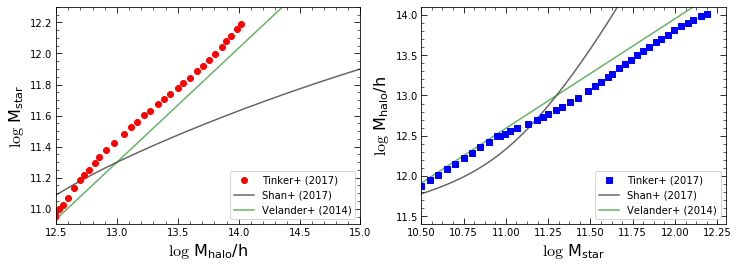

In [136]:
plt.figure(figsize=(12,4));
plt.subplot(121);
plt.plot(mhalo,mstar,'ro',label='Tinker+ (2017)');
plt.plot(shan_mhalo,shan_mstar,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.plot(velander_mhalo,shan_mstar,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.xlabel(r'$\log \ M_{halo}/h$',fontsize=16);
plt.ylabel(r'$\log \ M_{star}$',fontsize=16);
plt.xlim(12.5,15.) ; plt.ylim(10.9,12.3); #Match Figure 10
plt.legend(loc='lower right');

plt.subplot(122);
plt.plot(mstar,mhalo,'bs',label='Tinker+ (2017)');
plt.plot(shan_mstar,shan_mhalo,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.plot(shan_mstar,velander_mhalo,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
#plt.plot(shan_mstar,velander_mhalo-0.25,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}/h$',fontsize=16);
plt.xlim(10.5,12.3) ; plt.ylim(11.4,14.1);
plt.legend(loc='lower right');

**N.B.** The halo masses from Tinker need an $h^{-1}$ correction that the others _seem_ not to need.

### 1.3 Fit the distribution as a function of stellar mass

Now we fit the Tinker results with a function to apply to objects above stellar masses M$_{star} \geq 10^{11}$ M$_\odot$.

In [137]:
from astropy.modeling import models, fitting
from pyND.abs import plotzero

fitter = fitting.LevMarLSQFitter()
linfitter = fitting.LinearLSQFitter()

In [152]:
cheb1 = models.Chebyshev1D(degree=5)
cheb_fit = linfitter(cheb1, mstar, mhalo)

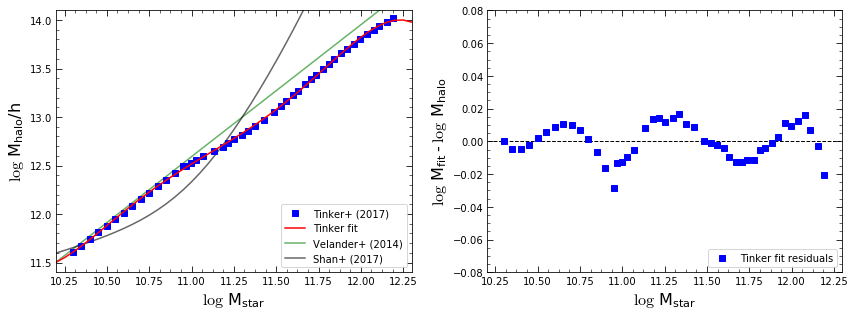

In [153]:
plt.figure(figsize=(12,4.5));
plt.subplot(121);
plt.plot(mstar,mhalo,'bs',label='Tinker+ (2017)');
plt.plot(shan_mstar,cheb_fit(shan_mstar),'-r',label='Tinker fit')
plt.plot(shan_mstar,velander_mhalo,'-g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.plot(shan_mstar,shan_mhalo,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}/h$',fontsize=16);
plt.xlim(10.2,12.3) ; plt.ylim(11.4,14.1);
plt.legend(loc='lower right');

plt.subplot(122);
plt.plot(mstar,cheb_fit(mstar)-mhalo,'bs',label='Tinker fit residuals');
plotzero()
plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{fit} - \log \ M_{halo}$',fontsize=16);
plt.xlim(10.2,12.3) ; plt.ylim(-0.08,0.08);
plt.legend(loc='lower right');
plt.tight_layout();

### 1.3 Incorporate the fit into a new model
The fit looks quite good, with residuals ≤0.03 dex. 

The next step is to extract the Chebyshev polynomial coefficients in order to allow a general fit (or else refit it each time, but that seems inefficient).

The results are stored in the `parameters` attribute:

In [154]:
cheb_fit
cheb_fit.domain

<Chebyshev1D(5, c0=12.81806600627276, c1=1.2018634412571902, c2=0.013199452285390979, c3=0.01775015568831073, c4=-0.029254096888480078, c5=-0.025509308396318747)>

[10.300000000000001, 12.19191]

When defining this in future code, we can set the parameters of a 5th-order Chebyshev model:

In [155]:
smhm_fit = models.Chebyshev1D(5, c0=12.81806600627276, c1=1.2018634412571902, 
                              c2=0.013199452285390979, c3=0.01775015568831073, 
                              c4=-0.029254096888480078, c5=-0.025509308396318747,
                             domain=[10.3, 12.19191])

The results of the code can be found in `pyND.gal.halos.smhm_tinker`.

## 2. Testing `pyND.gal.halos.smhm_tinker`


In [156]:
from pyND.gal import halos

reload(halos);
tinker_mhalo = halos.smhm_tinker(shan_mstar,0.5);

In [157]:
#Behroozi+ (2010)
from pyND.gal.halos import smhm_behroozi
b10_mhalo = smhm_behroozi(shan_mstar,0.5)

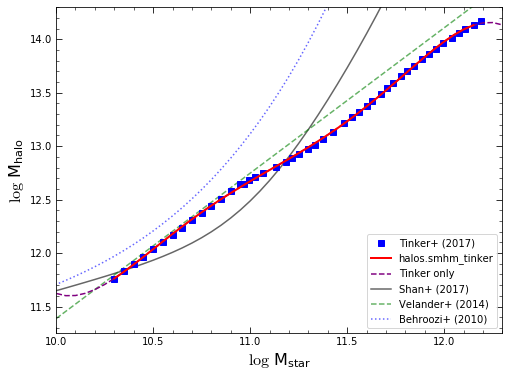

In [160]:
plt.figure(figsize=(8,6));
plt.plot(mstar,mhalo-hshift,'bs',label='Tinker+ (2017)');
plt.plot(shan_mstar,tinker_mhalo,'-r',label='halos.smhm_tinker',linewidth=2,zorder=6);
plt.plot(shan_mstar,smhm_fit(shan_mstar)-hshift,'--',color='purple',label='Tinker only');
plt.plot(shan_mstar,shan_mhalo-hshift,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.plot(shan_mstar,velander_mhalo-hshift,'--g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.plot(shan_mstar,b10_mhalo,':b',zorder=0,alpha=0.6,label='Behroozi+ (2010)');

plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}$',fontsize=16);
plt.xlim(10.,12.3) ; plt.ylim(11.25,14.3);
plt.legend(loc='lower right');

## 3. Comparing Tinker and Rodriguez-Puebla results


In [161]:
from pyND.gal import halos

reload(halos);
tinker_mhalo = halos.smhm_tinker(shan_mstar,0.5);
rp17_mhalo = halos.smhm_rodriguez(shan_mstar,0.5);

In [162]:
#Behroozi+ (2010)
from pyND.gal.halos import smhm_behroozi
b10_mhalo = smhm_behroozi(shan_mstar,0.5)

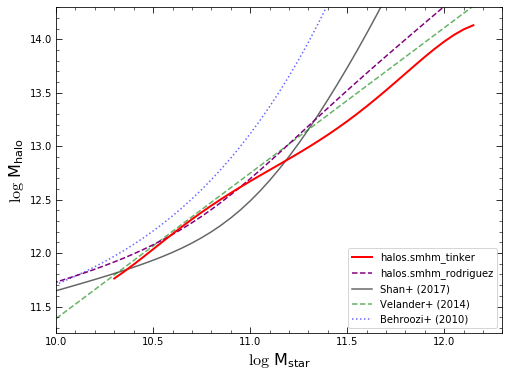

In [163]:
plt.figure(figsize=(8,6));
plt.plot(shan_mstar,tinker_mhalo,'-r',label='halos.smhm_tinker',linewidth=2,zorder=6);
plt.plot(shan_mstar,rp17_mhalo,'--',color='purple',label='halos.smhm_rodriguez');
plt.plot(shan_mstar,shan_mhalo-hshift,'-k',zorder=0,alpha=0.6,label='Shan+ (2017)');
plt.plot(shan_mstar,velander_mhalo-hshift,'--g',zorder=0,alpha=0.6,label='Velander+ (2014)');
plt.plot(shan_mstar,b10_mhalo,':b',zorder=0,alpha=0.6,label='Behroozi+ (2010)');

plt.xlabel(r'$\log \ M_{star}$',fontsize=16);
plt.ylabel(r'$\log \ M_{halo}$',fontsize=16);
plt.xlim(10.,12.3) ; plt.ylim(11.25,14.3);
plt.legend(loc='lower right');